# 初始化环境

In [1]:
# 初始化配置信息
import os
memory = '10g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import StorageLevel
spark = (SparkSession
        .builder
        .appName("文本分类器")
        .master('local[4]')
        .getOrCreate()
        )

# 文本案例演示

基于随机森林的新闻分类任务

## 初始化数据

In [2]:
spark_sinanews = spark.read.json("data/sinaNews_201501.json")
spark_sinanews.show(5)

+-------------+-------------------------------------+
|channel_title|                                 text|
+-------------+-------------------------------------+
|         体育|新浪体育讯　中超有两大洋帅。南有恒...|
|         体育|            \n\n2015年1月1 日，距 ...|
|         体育|        新浪体育讯　从2014年11月27...|
|         体育|  新浪体育讯　澳大利亚A联赛(简称澳...|
|         体育|  新浪体育讯　北京时间1月1日，洛杉...|
+-------------+-------------------------------------+
only showing top 5 rows



## 清洗数据

In [3]:
spark_sinanews.printSchema()

root
 |-- channel_title: string (nullable = true)
 |-- text: string (nullable = true)



In [4]:
#存在空的text,选择文章长度大于20的
spark_sinanews = spark_sinanews.select("channel_title","text").filter(length("text")>20)

In [5]:
spark_sinanews.count()

11040

In [6]:
spark_sinanews

DataFrame[channel_title: string, text: string]

## 定义udf 函数 对数据进行分词

In [7]:
import jieba
from pyspark.sql.types import StringType
jieba.initialize()

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Administrator\AppData\Local\Temp\jieba.cache
Loading model cost 0.666 seconds.
Prefix dict has been built successfully.


In [8]:
# 自定义函数
def cut_words(input_str):
    if not jieba.dt.initialized:
        jieba.initialize()   
    ret = " ".join([w for w in jieba.lcut(input_str)])
    return ret

In [9]:
# 向Spark注册自定义函数
preprocess_udf = udf(cut_words, StringType())

In [10]:
# 添加新列
spark_sinanews = spark_sinanews.withColumn("text_words",preprocess_udf("text"))

In [11]:
spark_sinanews.show(3)

+-------------+-------------------------------------+-------------------------------+
|channel_title|                                 text|                     text_words|
+-------------+-------------------------------------+-------------------------------+
|         体育|新浪体育讯　中超有两大洋帅。南有恒...|新浪 体育讯 　 中超 有 两大 ...|
|         体育|            \n\n2015年1月1 日，距 ...|         \n \n 2015 年 1 月 ...|
|         体育|        新浪体育讯　从2014年11月27...|   新浪 体育讯 　 从 2014 年...|
+-------------+-------------------------------------+-------------------------------+
only showing top 3 rows



In [12]:
spark_sinanews.persist(storageLevel=StorageLevel(True,False,False,False)) #设置缓存点

DataFrame[channel_title: string, text: string, text_words: string]

## 对类别进行编码

In [13]:
spark_sinanews.groupBy('channel_title').count().orderBy(col("count").desc()).show()  

+-------------+-----+
|channel_title|count|
+-------------+-----+
|         财经| 6183|
|         体育| 4857|
+-------------+-----+



In [14]:
from pyspark.ml.feature import StringIndexer, IndexToString

# 字符->编码
label_stringIdx = StringIndexer(inputCol="channel_title", outputCol="label").fit(spark_sinanews) 

# 编码->字符   用来看预测结果的
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=label_stringIdx.labels)

## 分词 与 去除停用词

In [18]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# 分词
tokenizer = Tokenizer(inputCol="text_words", outputCol="words")

with open("data/my_stop_words.txt",encoding="utf-8") as f:
    stop_words = list(f.read().split("\n"))

# 停用词
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(stop_words)

## BOW 特征

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer

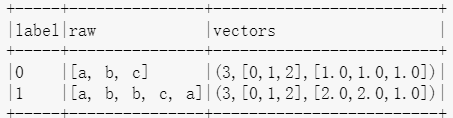

In [20]:
#计算总的字数
vocab_tmp = spark_sinanews.select('text_words').rdd.flatMap(lambda line: line['text_words'].split(" "))

vocab =  vocab_tmp.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b)
                                                    
vocab.count()
#  169230

169230

In [21]:
# bag of words count
# CountVectorizer将根据语料库中的词频排序选出前vocabSize个词  由于内存限制，取小一些
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000) 

# 1、分词 2、去除停用词 3、bow特征  4、y标签转换
pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(spark_sinanews)
dataset = pipelineFit.transform(spark_sinanews)

In [23]:
dataset.show(1)

+-------------+-------------------------------------+-------------------------------+----------------------------+-----------------------------+--------------------+-----+
|channel_title|                                 text|                     text_words|                       words|                     filtered|            features|label|
+-------------+-------------------------------------+-------------------------------+----------------------------+-----------------------------+--------------------+-----+
|         体育|新浪体育讯　中超有两大洋帅。南有恒...|新浪 体育讯 　 中超 有 两大 ...|[新浪, 体育讯, 　, 中超, ...|[新浪, 体育讯, 中超, 两大,...|(10000,[4,11,13,1...|  1.0|
+-------------+-------------------------------------+-------------------------------+----------------------------+-----------------------------+--------------------+-----+
only showing top 1 row



In [32]:
dataset.select("text","words","filtered","features","label").show(3)

+-------------------------------------+----------------------------+-----------------------------+--------------------+-----+
|                                 text|                       words|                     filtered|            features|label|
+-------------------------------------+----------------------------+-----------------------------+--------------------+-----+
|新浪体育讯　中超有两大洋帅。南有恒...|[新浪, 体育讯, 　, 中超, ...|[新浪, 体育讯, 中超, 两大,...|(10000,[4,11,13,1...|  1.0|
|            \n\n2015年1月1 日，距 ...|       [, , , , 2015, 年,...|     [2015, 年, 月, 日, 设...|(10000,[0,1,2,4,6...|  1.0|
|        新浪体育讯　从2014年11月27...| [新浪, 体育讯, 　, 从, 2...|   [新浪, 体育讯, 2014, 年...|(10000,[0,1,2,4,6...|  1.0|
+-------------------------------------+----------------------------+-----------------------------+--------------------+-----+
only showing top 3 rows



## 切分训练集 测试集

In [33]:
dataset.persist(storageLevel=StorageLevel(True,False,False,False))

DataFrame[channel_title: string, text: string, text_words: string, words: array<string>, filtered: array<string>, features: vector, label: double]

In [34]:
# set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 7760
Test Dataset Count: 3280


## 随机森林模型

In [35]:
%%time
from pyspark.ml.classification import RandomForestClassifier

# 随便拍一个参数
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, countVectors, label_stringIdx, rf, labelConverter])

(trainingData, testData) = spark_sinanews.randomSplit([0.7, 0.3])
trainingData.persist()
testData.persist()

# Train model. This also runs the indexers.
model = pipeline.fit(trainingData)

predictions = model.transform(testData)

CPU times: total: 46.9 ms
Wall time: 18.6 s


In [36]:
# Select example rows to display.
predictions.select("filtered", 'channel_title', "features", "prediction", "label", 'predictedLabel').show(5)

+------------------------------+-------------+--------------------+----------+-----+--------------+
|                      filtered|channel_title|            features|prediction|label|predictedLabel|
+------------------------------+-------------+--------------------+----------+-----+--------------+
|      [2015, 年, 月, 日, 设...|         体育|(10000,[0,1,2,4,6...|       1.0|  1.0|          体育|
|  [裕裕, 体坛, 周, 报, 驻沪...|         体育|(10000,[0,1,2,4,6...|       1.0|  1.0|          体育|
|[仅理, 葛爱平, 亚洲杯, 郑窃...|         体育|(10000,[0,2,3,6,1...|       1.0|  1.0|          体育|
|  [伞飞, 飞飞, 伞, 故人, 头...|         体育|(10000,[0,2,4,5,8...|       1.0|  1.0|          体育|
|   [傈, 尽尽, 特派, 首, 叉,...|         体育|(10000,[0,1,4,12,...|       1.0|  1.0|          体育|
+------------------------------+-------------+--------------------+----------+-----+--------------+
only showing top 5 rows



In [37]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

f1_score = evaluator.evaluate(predictions)
print("F1 Score:", f1_score)

F1 Score: 0.9554650517302742


In [38]:
spark.stop()